In [119]:
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [120]:
import numpy as np

from scipy.stats import poisson, norm, chi2

from matplotlib import pyplot as plt

from datetime import datetime
datetime_format = "%H:%M:%S %d/%m/%Y"

from modules import utils, fitting
import importlib
importlib.reload(utils)
importlib.reload(fitting)

utils.set_plot_configs()

In [121]:
field_idx = {
    0 : 'Event',
    1 : 'Time',
    2 : 'Date',
    # 3 : 'TimeStamp',
    4 : 'ADC1',
    5 : 'ADC2',
    6 : 'SiPM',
    7 : 'Temp',
    8 : 'Pressure',
    9 : 'DeadTime',
    10 : 'Coincident'
}

def time_from_datetime(timestamp,base_timestamp='0:00:09 1/1/2019'):
    reference_time = datetime.strptime(base_timestamp,datetime_format)
    time = datetime.strptime(timestamp,datetime_format)
    return (time - reference_time).total_seconds()

In [122]:
CosmicWatch_file_1 = 'data/2025-02-13/MaxBorn.txt'
CosmicWatch_file_2 = 'data/2025-02-13/SallyRide.txt'

In [123]:
class CosmicWatchMeasurement:
    """
    A class to process and analyze CosmicWatch data.

    Attributes:
        interval (int): Time interval (in seconds) for binning the data.
        n_interval (int): Number of intervals used for statistical analysis.

        count (numpy.ndarray): Binned event counts in each interval.
        count_err (numpy.ndarray): Poisson error associated with each count bin.
        time_bins (numpy.ndarray): Time bin edges.
        time_bin_centers (numpy.ndarray): Centers of the time bins.

        avg_count (numpy.ndarray): Cumulative average count over n_interval bins.
        avg_count_err (numpy.ndarray): Error associated with avg_count.
        alt_avg_count (numpy.ndarray): Alternative cumulative average count for comparison.
        altavg_count_err (numpy.ndarray): Error associated with alt_avg_count.

        count_bins (numpy.ndarray): Binned count values for the count distribution.
        count_freq (numpy.ndarray): Normalized frequency of count occurrences.
        count_freq_err (numpy.ndarray): Error associated with count_freq.

    Methods:
        _read_CosmicWatch_data(data_file, only_coincident=True):
            Reads and processes CosmicWatch data from a file, storing relevant fields.

        _bin_data_to_intervals():
            Bins the time-series data into fixed-length intervals and computes errors.

        _get_avg_binned_count():
            Computes the cumulative average count over n_interval bins and its associated error.

        _get_count_distribution():
            Computes the count distribution histogram and normalizes the frequency.

    Args:
        data_file (str): Path to the CosmicWatch data file.
        interval (int, optional): Binning interval in seconds. Default is 10.
        n_interval (int, optional): Number of intervals used for averaging and distribution analysis. Default is 100.
    """

    def __init__(self,
                 data_file,
                 interval=10,
                 n_interval=100,):
        
        self._read_CosmicWatch_data(data_file)

        self.interval = interval
        self._bin_data_to_intervals()

        self.n_interval = n_interval
        self._get_avg_binned_count()
        self._get_count_distribution()

    def _read_CosmicWatch_data(self,data_file,only_coincident=True):
        data = {
            field : [] for idx,field in field_idx.items() if idx != 2
        }

        with open(data_file, 'r') as f:
            for line in f.readlines():
                if line.startswith('#'):
                    continue
                
                line_data = line.split()

                if only_coincident and line_data[10] != '1':
                    continue

                for idx, field in field_idx.items():
                    if idx == 1:
                        data['Time'].append(time_from_datetime(line_data[1] + ' ' + line_data[2]))
                    elif idx == 2:
                        continue
                    else:
                        data[field].append(float(line_data[idx]))

        for field in data:
            setattr(self,field,np.array(data[field]))

    def _bin_data_to_intervals(self):
        count, time_bins = np.histogram(self.Time,bins=np.arange(0,self.Time[-1],self.interval))
        self.count = count
        self.count_err = np.sqrt(count)

        self.time_bins = time_bins
        self.time_bin_centers = (time_bins[1:] + time_bins[:-1]) / 2

    def _get_avg_binned_count(self):
        self.avg_count = np.cumsum(self.count[:self.n_interval]) / np.arange(1,self.n_interval+1)
        self.avg_count_err = np.sqrt(np.cumsum(self.count_err[:self.n_interval]**2)) /  np.arange(1,self.n_interval+1)

        self.alt_avg_count = np.cumsum(self.count[self.n_interval:2*self.n_interval]) / np.arange(1,self.n_interval+1)
        self.alt_avg_count_err = np.sqrt(np.cumsum(self.count_err[self.n_interval:2*self.n_interval]**2)) /  np.arange(1,self.n_interval+1)

    def _get_count_distribution(self):
        count_freq, count_bins = np.histogram(self.count[:self.n_interval],bins=np.arange(self.count.max()+2)-0.5)
        count_freq_err = np.sqrt(count_freq)

        freq_normalizer = 1 / np.sum(count_freq) / (count_bins[1] - count_bins[0])
        
        self.count_bins = np.arange(self.count.max()+1)
        self.count_freq = count_freq * freq_normalizer
        self.count_freq_err = count_freq_err * freq_normalizer

In [124]:
cosmic_watch = CosmicWatchMeasurement(CosmicWatch_file_1,interval=100)

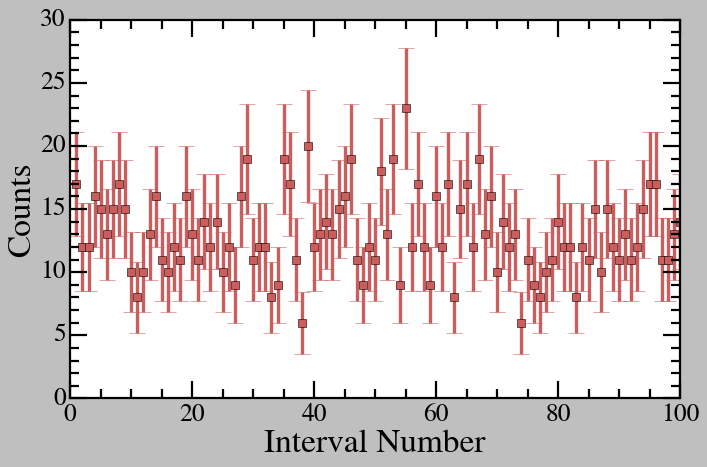

In [125]:
n_interval = 100

fig, ax = plt.subplots(figsize=(9,6))

ax.errorbar(np.arange(n_interval)+1,
            cosmic_watch.count[:n_interval],
            yerr=cosmic_watch.count_err[:n_interval],
            fmt=' s',markersize=7.5,elinewidth=3,capsize=7.5,
            color='indianred')

ax.set_xlabel('Interval Number')
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

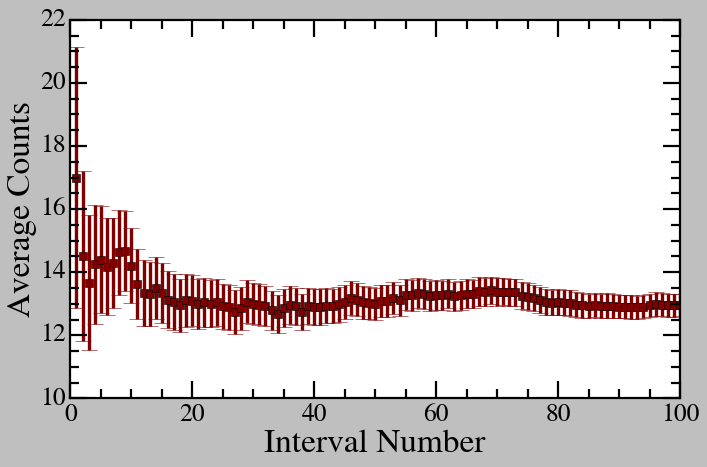

In [126]:
fig, ax = plt.subplots(figsize=(9,6))

ax.errorbar(np.arange(n_interval)+1,
            cosmic_watch.avg_count,
            yerr=cosmic_watch.avg_count_err,
            fmt=' s',markersize=7.5,elinewidth=3,capsize=7.5,
            color='maroon')

ax.set_xlabel('Interval Number')
ax.set_ylabel('Average Counts')

plt.tight_layout()
plt.show()

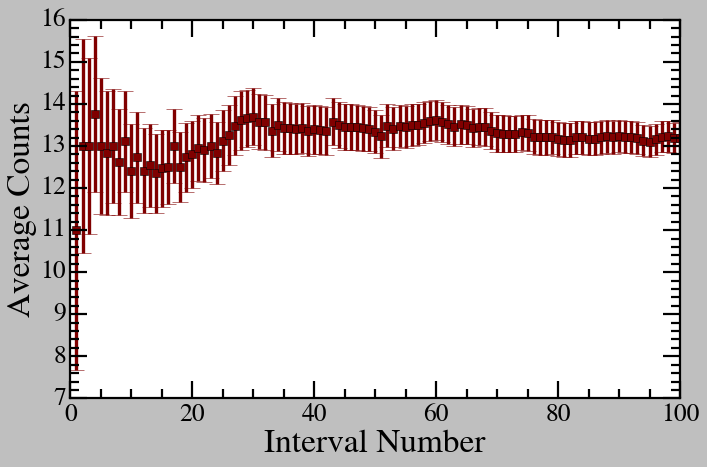

In [127]:
fig, ax = plt.subplots(figsize=(9,6))

ax.errorbar(np.arange(n_interval)+1,
            cosmic_watch.alt_avg_count,
            yerr=cosmic_watch.alt_avg_count_err,
            fmt=' s',markersize=7.5,elinewidth=3,capsize=7.5,
            color='maroon')

ax.set_xlabel('Interval Number')
ax.set_ylabel('Average Counts')

plt.tight_layout()
plt.show()

In [128]:
print(cosmic_watch.avg_count[-1],cosmic_watch.avg_count_err[-1])
print(cosmic_watch.alt_avg_count[-1],cosmic_watch.alt_avg_count_err[-1])

12.96 0.36
13.2 0.36331804249169897


In [129]:
class PoissonFitter(fitting.BaseFitter):
    def __init__(self, 
                 p_bin_centers, p_hist, p_hist_err,
                 p_mean):
        mask = p_hist > 0

        super().__init__(x=p_bin_centers[mask],
                         y=p_hist[mask],
                         yerr=p_hist_err[mask])
        
        self.p_mean = p_mean
        
    def _get_initial_guess(self):
        return [self.p_mean]
    
    def _get_model(self,x,params):
        return poisson.pmf(x, params[0])

class GaussianFitter(fitting.BaseFitter):
    def __init__(self, 
                 g_bin_centers, g_hist, g_hist_err,
                 g_median, g_mad):
        mask = g_hist > 0

        super().__init__(x=g_bin_centers[mask],
                         y=g_hist[mask],
                         yerr=g_hist_err[mask])

        self.g_median = g_median
        self.g_mad = g_mad
        
    def _get_initial_guess(self):
        return [self.g_median, self.g_mad]
    
    def _get_model(self,x,params):
        return norm.pdf(x, loc=params[0], scale=params[1])

0.718022022678389 0.8554874975372206
{'params': array([11.88144819,  3.42347   ]), 'e_params': array([0.22468663, 0.18189687]), 'chisqr': 16.20615765725028, 'alpha': 0.23817647624661165, 'cov': array([[ 0.05048408, -0.02069991],
       [-0.02069991,  0.03308647]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


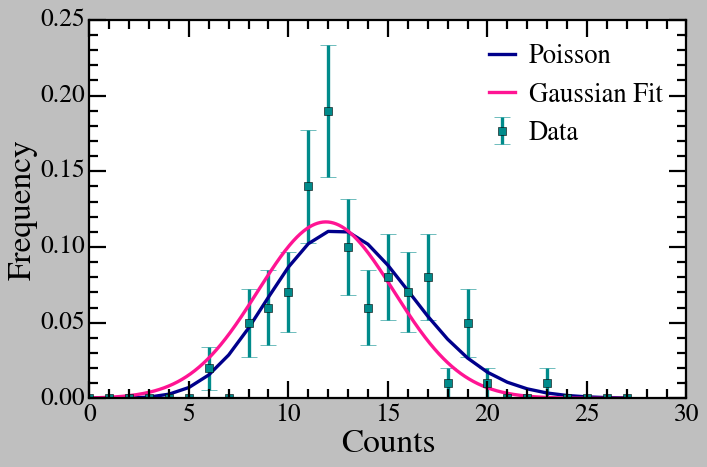

In [130]:
fig, ax = plt.subplots(figsize=(9,6))

ax.errorbar(cosmic_watch.count_bins,
            cosmic_watch.count_freq,
            yerr=cosmic_watch.count_freq_err,
            fmt=' s',markersize=7.5,elinewidth=3,capsize=7.5,
            color='darkcyan',label='Data')

ax.plot(cosmic_watch.count_bins,
        poisson.pmf(cosmic_watch.count_bins,cosmic_watch.avg_count[-1]),
        color='darkblue',label='Poisson')

poisson_fitter = PoissonFitter(cosmic_watch.count_bins,
                               cosmic_watch.count_freq,
                               cosmic_watch.count_freq_err,
                               cosmic_watch.avg_count[-1])
poisson_chisqr = poisson_fitter._get_chisqr(poisson_fitter._get_initial_guess())
poisson_alpha = 1 - chi2.cdf(poisson_chisqr, len(cosmic_watch.count_bins) - 1)
print(poisson_chisqr/(len(cosmic_watch.count_bins) - 1), poisson_alpha)

gaussian_fitter = GaussianFitter(cosmic_watch.count_bins,
                                 cosmic_watch.count_freq,
                                 cosmic_watch.count_freq_err,
                                 cosmic_watch.avg_count[-1],
                                 np.sqrt(cosmic_watch.avg_count[-1]))
fitting_result = gaussian_fitter.fit()
print(fitting_result)

ax.plot(np.linspace(0,cosmic_watch.count.max(),1000),
        gaussian_fitter._get_model(np.linspace(0,cosmic_watch.count.max(),1000),fitting_result['params']),
        color='deeppink',label='Gaussian Fit')
        

ax.set_xlabel('Counts')
ax.set_ylabel('Frequency')

ax.legend(loc='upper right', ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5, fontsize=24)

plt.tight_layout()
plt.show()